# Koopman eigenfunction analysis

In this notebook we investigate the eigenfunctions of the Koopman operator. Those can be used to decompose the complex system dynamics into individual Koopman modes. We exemplify here how dynamical signatures of the cyclone tracks can be visualized and compare the dynamical characterisitcs, captured by the Koopman eigenfunctions, of the different cyclone basins.

## Plot eigenfunctions along trajectories

In this first part of the notebook we plot the eigenfunctions of the Koopman operator along the tropical cyclone tracks. The Koopman eigenfunctions capture the dynamical characterisitcs of the system. Exemplary, we focus here on the east pacific (EP) basin.

In [22]:
# %matplotlib inline
import os
from itertools import product
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from kooplearn.data import TensorContextDataset
from kooplearn.models import Kernel, NystroemKernel
from kooplearn.utils import topk
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.climada.tc_tracks_tools import (BASINS_ALL,
                                                     BASINS_SELECTION)
from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.data_utils import (
    LinearScaler, characteristic_length_scale_from_TCTracks,
    context_dataset_from_TCTracks, load_model, load_model_results,
    standardize_TensorContextDataset,
    standardized_context_dataset_from_TCTracks)
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom
from klearn_tcyclone.kooplearn.spectral_analysis import (
    get_df_evecs, get_top_k_ev_and_indices_below_zero, get_top_k_ev_below_zero,
    slide_by_scaling, time_lag_scaling, train_model)
from klearn_tcyclone.models_utils import predict_time_series
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.training_utils.training_utils import \
    extend_by_default_flag_values
from klearn_tcyclone.utils import check_time_steps_TCTracks

In [3]:
print(f"Basins are given by {BASINS_ALL}.")

Basins are given by ['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA'].


In [4]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"

flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1980, 2021],
    "model": model_str,
    "koopman_kernel_length_scale": 10.0,
    "koopman_kernel_rank": 50,
    "koopman_kernel_num_centers": 800,
    "context_length": 32,
    "koopman_kernel_reduced_rank": False,
    "time_step_h": 1.0,
}
flag_params = extend_by_default_flag_values(flag_params)


model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 600,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}

top_k = 30
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]

time_lag = 1
slide_by = 1

As an example we focus here on the East Pacific (EP) basin.

In [5]:
basins = BASINS_SELECTION[:1]
basin = basins[0]

In [ ]:
# Datasets
tc_tracks_dict = get_TCTrack_dict(
    basins=basins,
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)

for basin in basins:
    tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks_dict[basin].data, test_size=0.1, random_state=flag_params["seed"])
    tc_tracks_dict[basin] = {
        "train": tc_tracks_train,
        "test": tc_tracks_test,
    }

contexts = {}
for basin in basins:
    scaler = LinearScaler()
    tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
        tc_tracks_dict[basin]["train"],
        feature_list=feature_list,
        scaler=scaler,
        context_length=flag_params["context_length"],
        time_lag=time_lag,
        fit=True,
        periodic_shift=True,
        basin=basin,
    )
    tensor_context_test_standardized = standardized_context_dataset_from_TCTracks(
        tc_tracks_dict[basin]["test"],
        feature_list=feature_list,
        scaler=scaler,
        context_length=flag_params["context_length"],
        time_lag=time_lag,
        fit=False,
        periodic_shift=True,
        basin=basin,
    )

    contexts[basin] = {
        "train": tensor_context_train_standardized,
        "test": tensor_context_test_standardized,
    }
    

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2025-01-03 15:23:53,065 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-03 15:25:34,584 - climada.hazard.tc_tracks - WARNING - 232 storm events are discarded because no valid wind/pressure values have been found: 1980094N06181, 1980161N09249, 1980169N12250, 1980177N13259, 1980183N13250, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
       

Data entry 3 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 36 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 103 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 163 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 200 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 256 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 372 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 397 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 443 has been removed since it is shorter than th

We train a Koopman kernel model and evaluate its eigenfunctions on the test dataset.

In [13]:
# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
kernel = RBF(length_scale=model_config["length_scale"])
nys_rrr = NystroemKernelCustom(
    kernel=kernel,
    reduced_rank=model_config["reduced_rank"],
    svd_solver=model_config["svd_solver"],
    tikhonov_reg=model_config["tikhonov_reg"],
    rank=model_config["rank"],
    num_centers=model_config["num_centers"],
    rng_seed=model_config["rng_seed"],
)
nys_rrr = nys_rrr.fit(contexts[basin]["train"], slide_by=slide_by)

We select eigenfunctions to the `top_k` eigenvalues with largest real parts below one. These modes correspond to the slowest physical modes of the dynamics. The Koopman eigenfunctions are functions, and we can visualize them only when evaluated on the state space. We evaluate the Koopman eigenfunctions on the cyclone tracks contained in the training dataset.

In [39]:
dataset = contexts[basin]["train"]
# dataset = contexts[basin]["test"]

evals, evec_right = nys_rrr.eig(eval_right_on=dataset)

indices_k, evals_k = get_top_k_ev_and_indices_below_zero(evals, top_k)
evec_right_k = evec_right[:, indices_k]

# evec_idx = list(range(0, top_k))``
evec_idx = list(range(0, top_k, 5))

In the plot below we show six exemplary eigenfuctions. The cyclone tracks are colored according to the evaluated Koopman eigenfunctions.

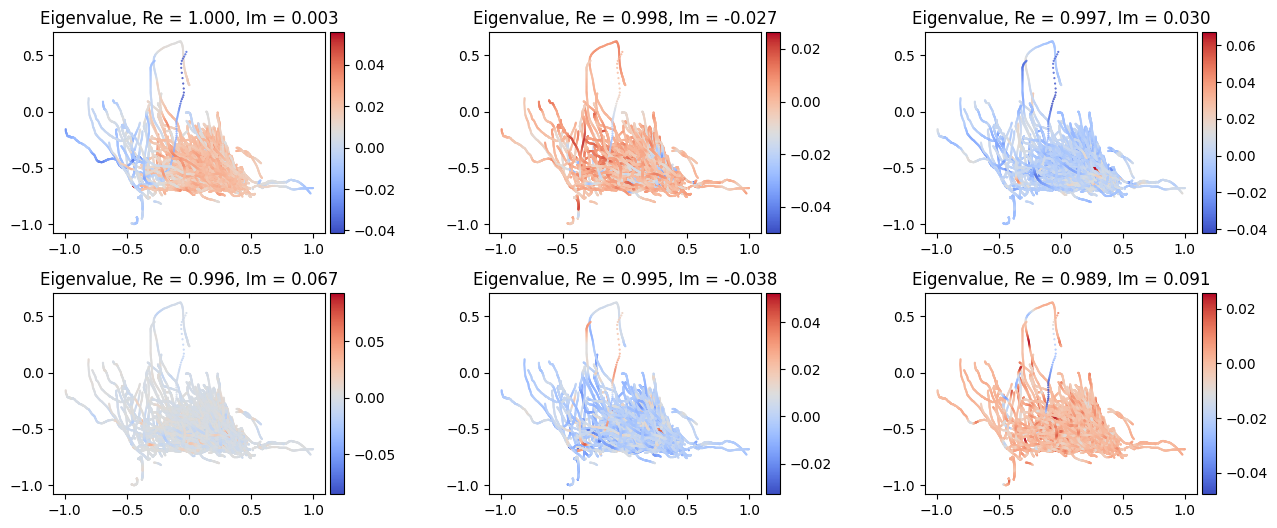

In [42]:
fig, ax = plt.subplots(2, 3) #, constrained_layout=True)
fig.set_size_inches(15, 6)

plt.subplots_adjust(
    hspace=.3, wspace=.5
)

idx = -1
cmap = plt.cm.coolwarm
ax_pos = list(product(range(2), range(3)))

for i, e_idx in enumerate(evec_idx):
    im = ax[ax_pos[i]].scatter(dataset.data[:idx, 0, 0], dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right_k[:idx, e_idx], s = 1)
    divider = make_axes_locatable(ax[ax_pos[i]])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[ax_pos[i]].set_title(f"Eigenvalue, Re = {evals_k[e_idx].real:.3f}, Im = {evals_k[e_idx].imag:.3f}")


We observe a smooth coloring of the full domain defined by the cyclone tracks in the dataset. This already shows that the Koopman kernel model is able to capture a consistent dynamical description of the full basin, not only of individual trajectories. Thus, our Koopman operator indeed characterizes the dynamics of the full basin. Furthermore, we note several special tracks, which have significantly different coloring than the surrounding tracks. These tracks apparently exhibit a significantly distinguished dynamics as compared to the bulk of the trajectories, and, thus, can be considered as outliers.

This suggest a potential application area of the Koopman eigenfunctions for outlier detection.

## Eigenfunction clustering

In the following we investigate the dynamical signatures of the different cyclone basins on the level of the Koopman eigenfunctions. For this we project the cyclone tracks onto the first `top_k` Koopman eigenfunctions of each basin. This results in a relatively low-dimensional dataset (compared to the dimensionality of the full cyclone tracks) which we visualize via nonlinear dimensionality reduction. For this we use the UMAP algorithm.

The training of the UMAP model is done in `train_models/koopman_spectral_analysis/koopman_spectral_data_eigenfunction_clustering.py`.

In [1]:
"""Trains UMAP model for eigenfunction clustering."""

import os
import pickle
import pandas as pd
from random import sample
import numpy as np
from itertools import product

import umap
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks_tools import BASINS_SELECTION
from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.data_utils import (
    load_model,
    standardized_context_dataset_from_TCTracks,
)
from klearn_tcyclone.kooplearn.spectral_analysis import (
    get_df_evecs,
)
from klearn_tcyclone.training_utils.training_utils import (
    extend_by_default_flag_values,
)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we set all the parameters as in `train_models/koopman_spectral_analysis/koopman_spectral_data_eigenfunction_clustering.py`.

In [2]:
current_file_dir_path = os.getcwd()
path_training_results = os.path.join(
    current_file_dir_path,
    "../train_models/",
    "training_results",
)

model_str = "Nystroem_RRR"



time_lag = 1
slide_by = 1
basins = BASINS_SELECTION
feature_list = [
    "lon",
    "lat",
    "max_sustained_wind",
    "radius_max_wind",
    "radius_oci",
    "central_pressure",
    "environmental_pressure",
]


flag_params = {
    "koopman_kernel_num_train_stops": 10,
    "year_range": [1980, 2021],
    "model": model_str,
    "koopman_kernel_length_scale": 10.0,
    "koopman_kernel_rank": 50,
    "koopman_kernel_num_centers": 800,
    "context_length": 32,
    "koopman_kernel_reduced_rank": False,
    "time_step_h": 1.0,
}
flag_params = extend_by_default_flag_values(flag_params)

model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 600,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}


Second we import the tropical cyclone data, which we want to visualize in the (reduced) eigenfunction space. We include the tropical cyclone data for the five most important basins EP, NA, SI, SP, WP.

(Data loading takes around 6 mins)

In [3]:
# Datasets
tc_tracks_dict = get_TCTrack_dict(
    basins=basins,
    time_step_h=flag_params["time_step_h"],
    year_range=flag_params["year_range"],
)

for basin in basins:
    tc_tracks_train, tc_tracks_test = train_test_split(
        tc_tracks_dict[basin].data, test_size=0.1, random_state=flag_params["seed"]
    )
    tc_tracks_dict[basin] = {
        "train": tc_tracks_train,
        "test": tc_tracks_test,
    }

2025-01-02 20:54:32,990 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2025-01-02 20:55:31,673 - climada.hazard.tc_tracks - WARNING - 232 storm events are discarded because no valid wind/pressure values have been found: 1980094N06181, 1980161N09249, 1980169N12250, 1980177N13259, 1980183N13250, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
       

2025-01-02 20:55:53,060 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-02 20:56:32,617 - climada.hazard.tc_tracks - WARNING - 57 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-02 20:56:50,918 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-02 20:57:40,808 - climada.hazard.tc_tracks - WARNING - 134 storm events are discarded because no valid wind/pressure values have been found: 1980015S18060, 1980032S14071, 1980056S15059, 1980068S13068, 1980075S11072, ...
2025-01-02 20:57:40,816 - climada.hazard.tc_tracks - WARNING - 9 storm events are discarded because only one valid timestep has been found: 1980002S15081, 1980005S11059, 1980009S14066, 1980010S20043, 1980010S22048, ...


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-02 20:58:02,321 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-02 20:58:34,305 - climada.hazard.tc_tracks - WARNING - 71 storm events are discarded because no valid wind/pressure values have been found: 1980085S11135, 1981022S13155, 1983027S21224, 1983082S15216, 1983347S16154, ...
2025-01-02 20:58:34,312 - climada.hazard.tc_tracks - WARNING - 1 storm events are discarded because only one valid timestep has been found: 1992358S07161.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


2025-01-02 20:58:48,874 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2025-01-02 21:00:12,406 - climada.hazard.tc_tracks - WARNING - 360 storm events are discarded because no valid wind/pressure values have been found: 1980076N06148, 1980087N13117, 1980181N10130, 1980197N15133, 1980225N11145, ...
2025-01-02 21:00:12,418 - climada.hazard.tc_tracks - WARNING - 2 storm events are discarded because only one valid timestep has been found: 1996318N33146, 2004327N16125.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


The results are plotted below. We choose a specific parameter combination as example. Other choices, for example for the UMAP hyperparameters or for the context window size, can be considered.

In [4]:
# umap_n_neighbors = 600
# umap_min_dist = 0.1
# training_data_size = 30
top_k = 10

training_data_size = 70
umap_n_neighbors = 600
umap_min_dist = 0.2

Pre-process data and compute Koopman eigenfunctions for each basin.

In [5]:
tc_tracks_dict_sample = {}
for basin in basins:
    tc_tracks_dict_sample[basin] = {
        "train": sample(tc_tracks_dict[basin]["train"], k=training_data_size),
    }


models = {}
scalers = {}
for basin in basins:
    flag_params["basin"] = basin
    best_model_dict, _ = load_model(flag_params, path_training_results)
    models[basin] = best_model_dict["model"]
    scalers[basin] = best_model_dict["scaler"]


contexts_sample = {}
for basin in basins:
    tensor_context_train_standardized = standardized_context_dataset_from_TCTracks(
        tc_tracks_dict_sample[basin]["train"],
        feature_list=feature_list,
        scaler=scalers[basin],
        context_length=flag_params["context_length"],
        time_lag=time_lag,
        fit=False,
        periodic_shift=True,
        basin=basin,
    )

    contexts_sample[basin] = {
        "train": tensor_context_train_standardized,
    }


df_evecs = get_df_evecs(
    {key: val["train"] for key, val in contexts_sample.items()},
    models=models,
    basins=basins,
    top_k=top_k,
)

D:\work\projects\repositories\koopman_learning_tropical_cyclone\klearn_tcyclone\data_utils.py:643: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_dict = torch.load

Data entry 47 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 0 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 12 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 27 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 3 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 31 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 67 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 65 has been removed since it is shorter than the 
                    context_length 32 times time_lag 1.
Data entry 3 has been removed since it is shorter than the 
      

Load the pre-trained UMAP model and embedd the eigenfunction coordinates into UMAP feature space.

UMAP transform (not training) takes around 3 minutes.

In [49]:
if model_config["reduced_rank"]:
    reduced_rank_str = "redrank"
else:
    reduced_rank_str = ""

    
file_name = "_".join(
    [
        f"cl{flag_params['context_length']}",
        f"tsteph{flag_params['time_step_h']}",
        f"nc{model_config['num_centers']}",
        f"tkreg{model_config['tikhonov_reg']}",
        reduced_rank_str,
        f"um_nneigh{umap_n_neighbors}",
        f"um_md{umap_min_dist}",
    ]
)

folder_name = "_".join(
    [
        "year_range",
        *map(str, flag_params["year_range"]),
        f"train_dsize{training_data_size}",
        f"topk{top_k}",
    ]
)

load_path = os.path.join(
    "../data/",
    "koopman_spectral_analysis/",
    "eigenfunction_clustering/",
    folder_name,
)

os.makedirs(load_path, exist_ok=True)

print("Load UMAP model.")
with open(os.path.join(load_path, "umap_" + file_name + ".pickle"), "rb") as file:
    umap_model = pickle.load(file)


data = df_evecs.drop(columns=["basin_data"])
embedding = umap_model.transform(data.to_numpy())
embedding = pd.DataFrame(embedding, columns=["x", "y"])
embedding["basin_data"] = list(df_evecs["basin_data"])

Load UMAP model.


Visualize the embedded data in two-dimensional feature space.

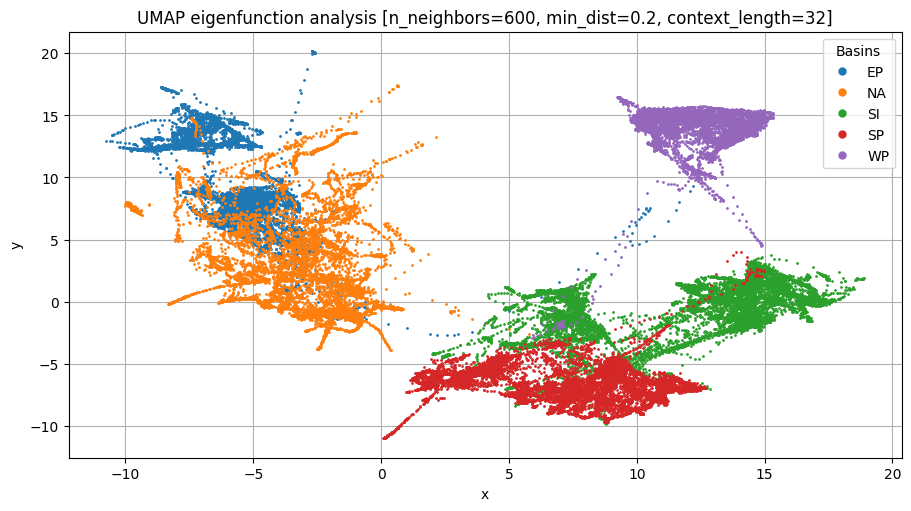

In [51]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
fig.set_size_inches(9,5)

for basin_data in basins:
    ax.plot(embedding[embedding["basin_data"] == basin_data]["x"], embedding[embedding["basin_data"] == basin_data]["y"], marker="o", linestyle="", label=basin_data, markersize=1)


ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"UMAP eigenfunction analysis [n_neighbors={umap_n_neighbors}, min_dist={umap_min_dist}, context_length={flag_params['context_length']}]")
ax.grid()
lgnd = ax.legend(title="Basins", markerscale=5.)

# save_path = os.path.join(
#     "../plots/", "koopman_spectral_analysis/", "eigenfunction_clustering/", folder_name
# )
# os.makedirs(save_path, exist_ok=True)
# fig.savefig(os.path.join(save_path, "umap_clustering_" + file_name + ".png"), bbox_inches='tight')